In [41]:
  #!/usr/bin/env python

try:
    import gi
    gi.require_version('NumCosmo', '1.0')
    gi.require_version('NumCosmoMath', '1.0')
except:
    pass

import math
import matplotlib.pyplot as plt
from gi.repository import GObject
from gi.repository import NumCosmo as nc
from gi.repository import NumCosmoMath as ncm
import numpy as np
from astropy.io import fits
from astropy.table import Table
import sys
sys.path.insert(0,'/home/henrique/Programas_Cosmologia/CLCosmo_Sim/cluster_abundance/')
sys.path.insert(0,'../scripts')

import pyccl as ccl
%load_ext autoreload
%autoreload 2
import CL_COUNT_class_cluster_abundance as cl_count
import time
from nc_ccl import create_nc_obj, ccl_cosmo_set_high_prec

ncm.cfg_init()
ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


initialize the `Cosmological models`

In [42]:
#CCL cosmology
cosmo_ccl = ccl.Cosmology(Omega_c = 0.30711 - 0.048254, Omega_b = 0.048254, h = 0.677, sigma8 = 0.8822714165197718, n_s=0.96, Omega_k = 0, transfer_function='eisenstein_hu')
ccl_cosmo_set_high_prec (cosmo_ccl)

cosmo, dist, ps_lin, ps_nln, hmfunc = create_nc_obj (cosmo_ccl)

psf = hmfunc.peek_psf ()

initialize the `ClusterAbundance` object

In [43]:
#Numcosmo Cluster Abundance

#First we need to define the multiplicity function here we will use the tinker
mulf = nc.MultiplicityFuncTinker.new()
mulf.set_linear_interp (True)
mulf.set_mdef(nc.MultiplicityFuncMassDef.CRITICAL)
mulf.set_Delta(200)
#Second we need to construct a filtered power spectrum 

hmf = nc.HaloMassFunction.new(dist,psf,mulf)
hmf.set_area((0.25)*4*np.pi)

#Here we define the mass proxy in the first analysis is used the true mass and redshift of the clusters
cluster_m = nc.ClusterMass.new_from_name("NcClusterMassNodist{'lnM-min':<%20.15e>, 'lnM-max':<%20.15e>}" % (math.log(10)*np.log10(1e14),math.log(10)*np.log10(1e16)))
cluster_z = nc.ClusterRedshift.new_from_name("NcClusterRedshiftNodist{'z-min': <%20.15e>, 'z-max':<%20.15e>}" % (0.25,2))

ca = nc.ClusterAbundance.new(hmf,None)
mset = ncm.MSet.new_array([cosmo,cluster_m,cluster_z])
mset.pretty_log()
print('sigma8 = '+str(cosmo.sigma8(psf)))

#----------------------------------------------------------------------------------
# Model[03000]:
#   - NcHICosmo : Chevalier-Polarski-Linder parametrization
#----------------------------------------------------------------------------------
# Model parameters
#   -         H0[00]:  67.7                [FIXED]
#   -     Omegac[01]:  0.258856            [FIXED]
#   -     Omegak[02]:  0                   [FIXED]
#   -    Tgamma0[03]:  2.725               [FIXED]
#   -         Yp[04]:  0.24                [FIXED]
#   -       ENnu[05]:  3.046               [FIXED]
#   -     Omegab[06]:  0.048254            [FIXED]
#   -         w0[07]: -1                   [FIXED]
#   -         w1[08]:  0                   [FIXED]
#----------------------------------------------------------------------------------
# Model[05000]:
#   - NcHIPrim : Power Law model for primordial spectra
#----------------------------------------------------------------------------------
# Model parameters
#   - ln10e10ASA[00

In [44]:
#CCL Cluster Abundance
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncTinker08(cosmo_ccl, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo_ccl, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25)*4*np.pi

# Binned approach
Compute the 2D integral

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\log_{10}M_\beta}^{\log_{10}M_{\beta + 1}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}d\log_{10}M
$$

In [45]:

t0 = time.time()
#Bins definition
z_nodes = np.linspace(0.25, 2, 8)
log10M_nodes = np.linspace(14, 14.8, 11)
lnM_nodes = log10M_nodes * math.log(10)

#Numcosmo cluster counts in the bins

Numcosmo_Abundance = []
ca.prepare (cosmo, cluster_z, cluster_m)
for zl, zu in zip (z_nodes, z_nodes[1:]):
    nc_bin_mass = []
    for lnMl, lnMu in zip (lnM_nodes, lnM_nodes[1:]):
        Pbin = ca.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnMl], [lnMu], None, [zl], [zu], None)
        nc_bin_mass.append(Pbin)
    Numcosmo_Abundance.append(nc_bin_mass)

#Numcosmo_Abundance[i][j] is the number of clusters in i-th z_bin and j-th mass_bin


t1 = time.time()
print('time (seconds) = ' + str(t1-t0))

time (seconds) = 0.1842341423034668


In [46]:
#CCL cluster count in the bins
t0 = time.time()
CCL_Abundance_exact = clc.Cluster_Abundance_MZ(zbin_edges = z_nodes, proxybin_edges = log10M_nodes, method = 'exact')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
#CCL_Abundance_exact[i][j] is the number of clusters in i-th z_bin and j-th mass_bin

time (seconds) = 18.18240451812744


In [47]:
for zl, zu, ccl_a_z, nc_a_z in zip(z_nodes, z_nodes[1:], CCL_Abundance_exact, Numcosmo_Abundance):
    for lnMl, lnMu, ccl_a, nc_a in zip (lnM_nodes, lnM_nodes[1:], ccl_a_z, nc_a_z):
        print("(% 16.9g % 16.9g) (% 16.9g % 16.9g) % 16.9g cmp %.2e" % (lnMl / math.log(10), lnMu / math.log(10), zl, zu, ccl_a, math.fabs (nc_a/ccl_a - 1.0)))


(              14            14.08) (            0.25              0.5)        14733.166 cmp 1.54e-06
(           14.08            14.16) (            0.25              0.5)       11360.5226 cmp 1.11e-06
(           14.16            14.24) (            0.25              0.5)       8653.24547 cmp 2.36e-07
(           14.24            14.32) (            0.25              0.5)       6500.61431 cmp 1.10e-06
(           14.32             14.4) (            0.25              0.5)       4807.84091 cmp 9.61e-07
(            14.4            14.48) (            0.25              0.5)       3493.74401 cmp 5.73e-07
(           14.48            14.56) (            0.25              0.5)       2488.72882 cmp 5.85e-07
(           14.56            14.64) (            0.25              0.5)       1733.30467 cmp 6.05e-07
(           14.64            14.72) (            0.25              0.5)       1176.76975 cmp 1.38e-06
(           14.72             14.8) (            0.25              0.5)       776.

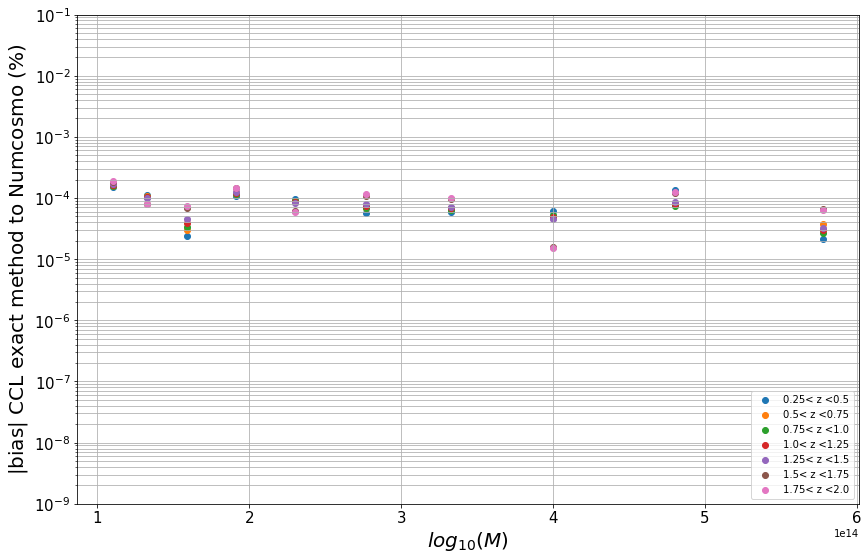

In [48]:
diff = []
for i in range(len(CCL_Abundance_exact)):
        diff.append(100*abs((Numcosmo_Abundance[i]-CCL_Abundance_exact[i])/Numcosmo_Abundance[i]))


plt.figure(figsize = (14,9))
plt.yscale('log')
z_ = [np.mean([z_nodes[i],z_nodes[i+1]]) for i in np.arange(len(z_nodes)-1)]
mass = [np.mean([10**log10M_nodes[i],10**log10M_nodes[i+1]]) for i in np.arange(len(log10M_nodes)-1)]
plt.tick_params(axis='both', which="both", labelsize= 15)
legend = []
for i in range(len(z_)):
        plt.scatter(mass, diff[:][i])
        legend.append(str(round(z_nodes[i],3))+'< z <'+str(round(z_nodes[i+1],3)))
plt.legend(legend,loc =4, fontsize = 10)
plt.grid(True, which="both" )
plt.ylabel('|bias| CCL exact method to Numcosmo $(\%)$', fontsize = 20)
plt.xlabel(r'$log_{10}(M)$', fontsize = 20)
plt.ylim(1e-9,1e-1)
plt.show()



#diff[i][j] is the percentual difference between Numcosmo and CCL cluster abundance in i-th z_bin and j-th mass_bin

# Un-binned approach

Compute $$\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M_i,z_i)}{d\log_{10}M_i}$$ for each masses and redshifts in a dark matter halo catalog

In [49]:
#Generates cluster count catalog data
ncdata = nc.DataClusterNCount.new(ca,'NcClusterRedshiftNodist','NcClusterMassNodist')
rng = ncm.RNG.pool_get("example_ca_sampling");
ncdata.init_from_sampling(mset,(0.25)*4*np.pi,rng)
ncdata.catalog_save("ca_nodist_unbinned_numcosmo.fits", True)

ncdata_fits = fits.open('ca_nodist_unbinned_numcosmo.fits')
#ncdata_fits.info()

ncdata_data =  ncdata_fits[1].data

ncdata_Table = Table(ncdata_data)
ncdata_Table.columns
ncdata_Table.sort('Z_TRUE')

display(ncdata_Table)

Z_OBS,LNM_OBS,Z_TRUE,LNM_TRUE
float64,float64,float64,float64
0.2500062503536331,32.97724304418643,0.2500062503536331,32.97724304418643
0.250009443721945,32.886550722457194,0.250009443721945,32.886550722457194
0.2500156338519822,32.52810402357876,0.2500156338519822,32.52810402357876
0.25002512036273244,33.02421226040638,0.25002512036273244,33.02421226040638
0.2500325477021221,32.37914832055271,0.2500325477021221,32.37914832055271
0.25004248482655317,32.72502510297693,0.25004248482655317,32.72502510297693
0.25006163395022124,32.2874099580188,0.25006163395022124,32.2874099580188
0.25006452641529614,33.66501197668367,0.25006452641529614,33.66501197668367
0.25006460753788906,32.24397511444356,0.25006460753788906,32.24397511444356


In [50]:
#Using Numcosmo
t0 = time.time()
d2n = []
for i in ncdata_Table:
    d2n.append(ca.d2n(cosmo,cluster_z,cluster_m,i[1],i[0]))
d2n = np.array(d2n)

t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
d2n


time (seconds) = 2.1058309078216553


array([ 72590.63055366,  83262.14432016, 138815.88275343, ...,
        28258.66761586,  13558.12488109,  46575.98342392])

In [51]:
#Using CCL
t0 = time.time()
log10M = np.array(ncdata_Table[1][:]/np.log(10))
multiplicity_exact = clc.multiplicity_function_individual_MZ(z = np.array(ncdata_Table[0][:]), logm =log10M, method = 'exact')
multiplicity_exact *= clc.sky_area/math.log(10)

t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
print(multiplicity_exact)



time (seconds) = 49.50598883628845
[ 72590.5843905   83262.25341206 138815.66531544 ...  28258.63562527
  13558.13804605  46576.08021727]


(1e-09, 1)

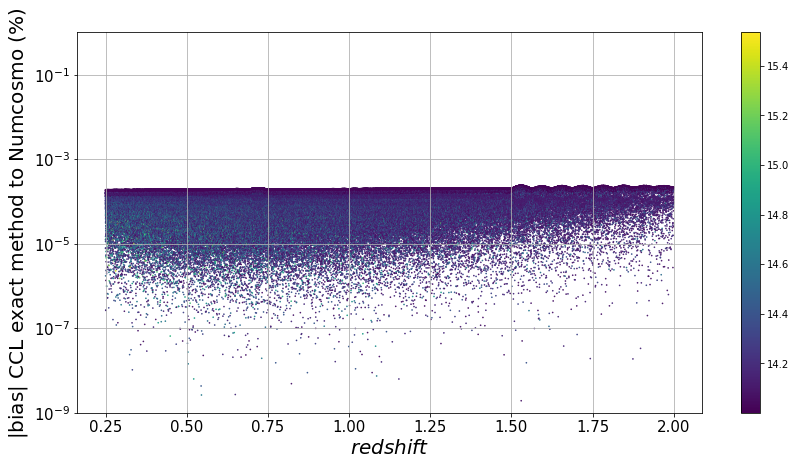

In [52]:
diff = abs(100*(multiplicity_exact-d2n)/d2n)

plt.figure(figsize = (14,7))
plt.yscale('log')
plt.tick_params(axis='both', which = 'major', labelsize= 15)
plt.scatter(ncdata_Table[0][:], diff, s = 0.4, c = log10M)
plt.colorbar()
plt.grid(True, which='both')
plt.xlabel(r'$redshift$', fontsize = 20)
plt.ylabel('|bias| CCL exact method to Numcosmo $(\%)$', fontsize = 20)
plt.ylim(10e-10,1)
